In [1]:
import pandas as pd
import numpy as np
import spacy
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from bs4 import BeautifulSoup
from html import unescape

In [2]:
train = pd.read_csv("Corona_NLP_train.csv")
test = pd.read_csv("Corona_NLP_test.csv")
data = pd.concat([train, test])

In [3]:
def makeClean(text):
    #Removing escaped tags if there is any
    text = BeautifulSoup(unescape(text), 'lxml').text
    #Removing the url links
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    #Removing the html tags
    text = re.sub(r'<.*?>', '', text)
    
    #Removing mentions
    text = re.sub(r'@\w+','',text)
    #Removing hashtags
    text=re.sub(r'#\w+','',text)
    
    #Lowercasing the text 
    text = text.lower()
    #Removing numbers
    text = re.sub(r"(?<=\d)(st|nd|rd|th)\b", '', text)
    text = re.sub('[0-9]+', '', text)
    
    #Converting the contractions into their corresponding standard form 
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don t", "do not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

   
    #Removing punctuation
    for char in text:
        if char in string.punctuation:
            text=text.replace(char, '')
    #Removing the extra spaces
    text = re.sub(r"\s+"," ",text).strip()
    
    return(text.strip())


# Tokenizing the data using NLTK package
stopwords = nltk.corpus.stopwords.words('english')

def nltkPreprocess(text):
#     stemmer = nltk.PorterStemmer()
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = word_tokenize(text)
#     tokens = [stemmer.stem(token) for token in tokens if token not in stopwords]
    tokensList = ' '.join(lemmatizer.lemmatize(token) for token in tokens if token not in stopwords)
    return str(tokensList).strip('[]')
#     return tokensList


#Tokenizing the data using spacy package

nlp = spacy.load("en_core_web_sm")
def spacyPreprocess(text):
    doc = nlp(text)
    tokensList = " ".join(token.lemma_ for token in doc if token.lemma_.isalpha() and not token.is_stop)
#     return str(tokensList).strip('[]')
    return tokensList



In [4]:
import warnings
warnings.filterwarnings('ignore')

#Applying the cleaning function on the original tweets

data["CleanedTweet"] = data["OriginalTweet"].map(lambda text: makeClean(text))

#Tokenizing by spacy
data["Tokenized_Spacy"] = data["CleanedTweet"].map(lambda text:spacyPreprocess(text))

#Tokenizing by NLTK
#data["Tokenized_nltk"] = data["CleanedTweet"].map(lambda text:nltkPreprocess(text))

In [5]:
#Inserting the Sentiment column into the new data frame. A 3-class Sentiment column was also created to have Negative, Neutral, and Positive classes.
data["SentToInt"] = data["Sentiment"].map({"Neutral":2, "Positive":3, "Negative":1, "Extremely Negative":0, "Extremely Positive":4})
data["Sentiment2"]= data["Sentiment"].map({"Neutral":"Neutral", "Positive":"Positive", "Negative":"Negative", "Extremely Negative":"Negative", "Extremely Positive":"Positive"})
data["Sent2ToInt"] = data["Sentiment2"].map({"Neutral":1, "Positive":2, "Negative":0})
data[['Sentiment', 'SentToInt', 'Sentiment2', 'Sent2ToInt']].head()

,Sentiment,SentToInt,Sentiment2,Sent2ToInt
0,Neutral,2,Neutral,1
1,Positive,3,Positive,2
2,Positive,3,Positive,2
3,Positive,3,Positive,2
4,Extremely Negative,0,Negative,0


## Specifying X and y

In [28]:

classCol = 'Sent2ToInt'
featureName = 'CleanedTweet'
X = data[featureName]
y = data[classCol]
targetLabels = ['Negative', 'Neutral', 'Positive']

## Vectorizing the labels by OneHotEncoder

In [20]:
# Vectorizing the labels by OneHotEncoder
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# label_encoder = LabelEncoder()
# onehot_encoder = OneHotEncoder(sparse=False)

# y_integers = label_encoder.fit_transform(y)
# y = onehot_encoder.fit_transform(y_integers.reshape((-1,1)))

# print(f'X shape: {X.shape}')
# print(f'y shape: {y.shape}')


## Vectorizing X

In [29]:
#Tokenizing and vectorizing the tweets by kers functions
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

X = pad_sequences(X, padding='post')
# y = y.reshape((-1,1))
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
wordSize = len(tokenizer.word_index)+1

X shape: (44955, 63)
y shape: (44955,)


## Splitting the data into train and test

In [30]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.15, stratify=y, random_state=41)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (38211, 63)
y_train shape: (38211,)
X_test shape: (6744, 63)
y_test shape: (6744,)


## RNN

In [23]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, GlobalMaxPool1D,BatchNormalization, Dropout
from keras.losses import SparseCategoricalCrossentropy


def rnnModel(embedding_dim = 100,hidden_dim = 100,lstm_2=False,
           n_dense_layers=0,n_nodes=64,denseLayerAct='relu',
           use_batchNorm=False,use_dropout=False,dropProb=0.5):
    
    
    model = Sequential()
    model.add(Embedding(wordSize, embedding_dim, input_length=X_train.shape[1]))
    model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True)))
    if lstm_2:
        model.add(Bidirectional(LSTM(int(hidden_dim/2), return_sequences=True)))
        
    model.add(GlobalMaxPool1D())
    # Add intermediate dense layers
    if n_dense_layers > 0:
        for i in range(n_dense_layers):
            model.add(Dense(n_nodes/(2^i), activation = denseLayerAct))
            if use_batchNorm:
                model.add(BatchNormalization())
            if use_dropout:
                model.add(Dropout(dropProb))
    
    model.add(Dense(3, activation = 'softmax'))       

    # Compile model
    model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy'])
    return model




#This function is taken from deep learning labs
import matplotlib.pyplot as plt
def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

# model = Sequential()
# model.add(Embedding(wordSize, embedding_dim, input_length=X_train.shape[1]))
# model.add(Bidirectional(LSTM(hidden_dim, return_sequences=True)))
# model.add(GlobalMaxPool1D())
# #model.add(Dense(64, activation = 'relu'))
# model.add(Dense(3, activation = 'softmax'))
          

# # Compile model

# model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
#               optimizer='adam',metrics=['accuracy'])




### Model1

In [24]:
model1 = rnnModel()
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 63, 100)           4058800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 63, 200)           160800    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 603       
Total params: 4,220,203
Trainable params: 4,220,203
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
batch_size = 32
epochs = 5


history1 = model1.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)
                    


Epoch 1/5
1075/1075 [==============================] - 94s 87ms/step - loss: 0.8241 - accuracy: 0.7194 - val_loss: 0.7056 - val_accuracy: 0.8441
Epoch 2/5
1075/1075 [==============================] - 94s 87ms/step - loss: 0.6662 - accuracy: 0.8848 - val_loss: 0.6894 - val_accuracy: 0.8592
Epoch 3/5
1075/1075 [==============================] - 95s 88ms/step - loss: 0.6311 - accuracy: 0.9213 - val_loss: 0.6829 - val_accuracy: 0.8660
Epoch 4/5
1075/1075 [==============================] - 97s 90ms/step - loss: 0.6146 - accuracy: 0.9371 - val_loss: 0.6752 - val_accuracy: 0.8736
Epoch 5/5
1075/1075 [==============================] - 96s 90ms/step - loss: 0.6058 - accuracy: 0.9459 - val_loss: 0.6716 - val_accuracy: 0.8781


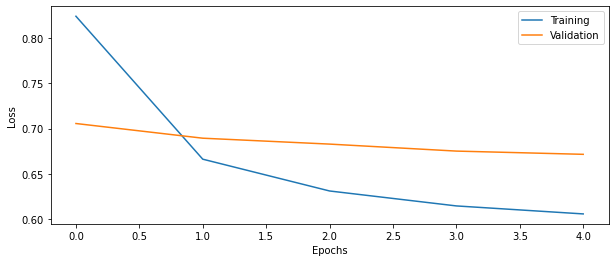

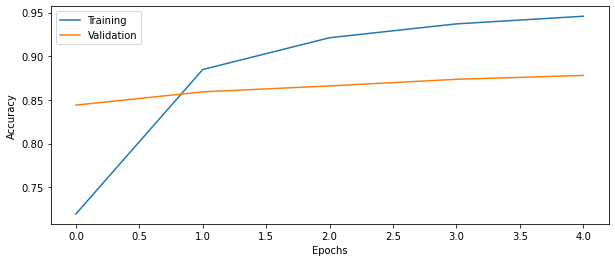

In [26]:
plot_results(history1)

In [27]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report

pred1 = model1.predict_classes(X_test)
print("\nPerformance on the test data\n")
print(classification_report(y_test, pred1, target_names=targetLabels))


# loss, acc = model.evaluate(X_test,y_test,verbose=0)
# print(f'Test loss: {loss}')
# print(f'Test Accuracy: {acc}')


Performance on the test data

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88      2555
     Neutral       0.89      0.82      0.85      1250
    Positive       0.87      0.90      0.88      2939

    accuracy                           0.88      6744
   macro avg       0.88      0.86      0.87      6744
weighted avg       0.88      0.88      0.88      6744



### Model2

In [164]:
model2 = rnnModel(n_dense_layers=1)
print(model2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 63, 100)           4058800   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 63, 200)           160800    
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                12864     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 4,232,659
Trainable params: 4,232,659
Non-trainable params: 0
_________________________________________________________________
None


In [165]:
batch_size = 32
epochs = 5
history2 = model2.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)
                    


Epoch 1/5
1075/1075 [==============================] - 91s 85ms/step - loss: 0.8230 - accuracy: 0.7174 - val_loss: 0.7098 - val_accuracy: 0.8383
Epoch 2/5
1075/1075 [==============================] - 91s 85ms/step - loss: 0.6727 - accuracy: 0.8764 - val_loss: 0.6965 - val_accuracy: 0.8527
Epoch 3/5
1075/1075 [==============================] - 93s 87ms/step - loss: 0.6430 - accuracy: 0.9066 - val_loss: 0.6891 - val_accuracy: 0.8587
Epoch 4/5
1075/1075 [==============================] - 94s 87ms/step - loss: 0.6274 - accuracy: 0.9236 - val_loss: 0.6887 - val_accuracy: 0.8626
Epoch 5/5
1075/1075 [==============================] - 94s 87ms/step - loss: 0.6182 - accuracy: 0.9329 - val_loss: 0.6793 - val_accuracy: 0.8700


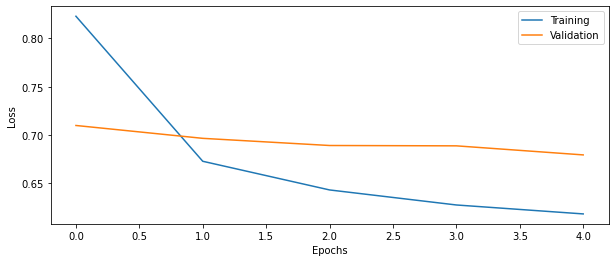

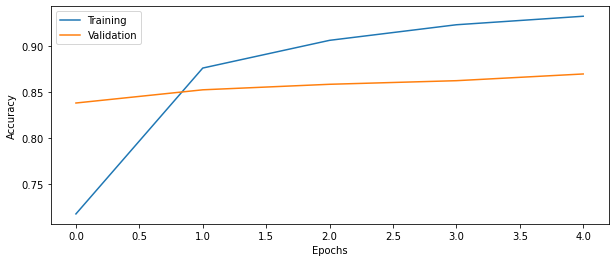

In [166]:
plot_results(history2)

In [167]:
pred2 = model2.predict_classes(X_test)
print(classification_report(y_test, pred2, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.86      0.88      0.87      2555
     Neutral       0.86      0.83      0.84      1250
    Positive       0.88      0.87      0.88      2939

    accuracy                           0.87      6744
   macro avg       0.86      0.86      0.86      6744
weighted avg       0.87      0.87      0.87      6744



### Model3

In [170]:
model3 = rnnModel(n_dense_layers=2,use_batchNorm=True ,use_dropout=True, dropProb=0.5)
print(model3.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 63, 100)           4058800   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 63, 200)           160800    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                12864     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

In [171]:
batch_size = 32
epochs = 5
history3 = model3.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)
                    


Epoch 1/5
1075/1075 [==============================] - 93s 87ms/step - loss: 0.8841 - accuracy: 0.6500 - val_loss: 0.7499 - val_accuracy: 0.7983
Epoch 2/5
1075/1075 [==============================] - 91s 85ms/step - loss: 0.7363 - accuracy: 0.8118 - val_loss: 0.7483 - val_accuracy: 0.7993
Epoch 3/5
1075/1075 [==============================] - 91s 84ms/step - loss: 0.6977 - accuracy: 0.8522 - val_loss: 0.7417 - val_accuracy: 0.8074
Epoch 4/5
1075/1075 [==============================] - 90s 84ms/step - loss: 0.6774 - accuracy: 0.8725 - val_loss: 0.7158 - val_accuracy: 0.8325
Epoch 5/5
1075/1075 [==============================] - 93s 86ms/step - loss: 0.6687 - accuracy: 0.8817 - val_loss: 0.7004 - val_accuracy: 0.8503


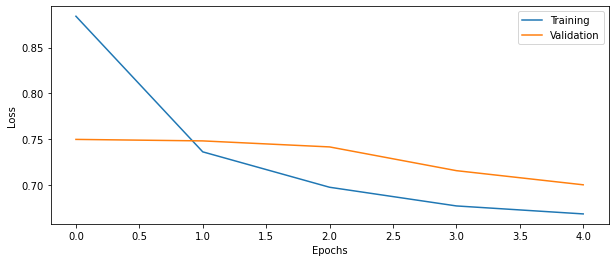

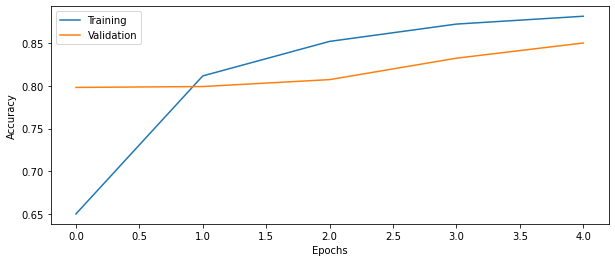

In [172]:
plot_results(history3)

In [173]:
pred3 = model3.predict_classes(X_test)
print(classification_report(y_test, pred3, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.85      0.83      0.84      2555
     Neutral       0.80      0.84      0.82      1250
    Positive       0.86      0.86      0.86      2939

    accuracy                           0.84      6744
   macro avg       0.84      0.84      0.84      6744
weighted avg       0.84      0.84      0.84      6744



### Model4

In [174]:
model4 = rnnModel(embedding_dim=264,n_dense_layers=1)
print(model4.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 63, 264)           10715232  
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 63, 200)           292000    
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 200)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)                12864     
_________________________________________________________________
dense_18 (Dense)             (None, 3)                 195       
Total params: 11,020,291
Trainable params: 11,020,291
Non-trainable params: 0
_________________________________________________________________
None


In [175]:
batch_size = 16
epochs = 10
history4 = model4.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)
                    

Epoch 1/10
2150/2150 [==============================] - 333s 155ms/step - loss: 0.7895 - accuracy: 0.7527 - val_loss: 0.7412 - val_accuracy: 0.8051
Epoch 2/10
2150/2150 [==============================] - 334s 156ms/step - loss: 0.6794 - accuracy: 0.8696 - val_loss: 0.6951 - val_accuracy: 0.8527
Epoch 3/10
2150/2150 [==============================] - 323s 150ms/step - loss: 0.6428 - accuracy: 0.9074 - val_loss: 0.6794 - val_accuracy: 0.8707
Epoch 4/10
2150/2150 [==============================] - 320s 149ms/step - loss: 0.6251 - accuracy: 0.9253 - val_loss: 0.6808 - val_accuracy: 0.8684
Epoch 5/10
2150/2150 [==============================] - 328s 153ms/step - loss: 0.6147 - accuracy: 0.9363 - val_loss: 0.6922 - val_accuracy: 0.8579
Epoch 6/10
2150/2150 [==============================] - 332s 155ms/step - loss: 0.6075 - accuracy: 0.9432 - val_loss: 0.6809 - val_accuracy: 0.8679
Epoch 7/10
2150/2150 [==============================] - 329s 153ms/step - loss: 0.6018 - accuracy: 0.9493 - val_

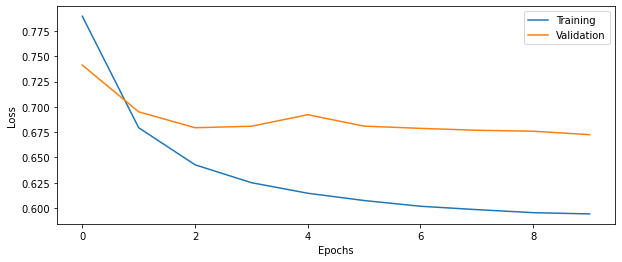

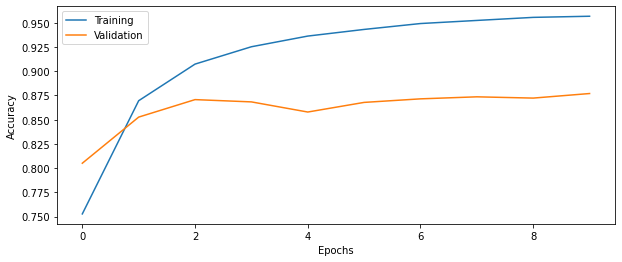

In [176]:
plot_results(history4)

In [177]:
pred4 = model4.predict_classes(X_test)
print(classification_report(y_test, pred4, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.84      0.89      0.86      2555
     Neutral       0.87      0.83      0.85      1250
    Positive       0.89      0.87      0.88      2939

    accuracy                           0.87      6744
   macro avg       0.87      0.86      0.86      6744
weighted avg       0.87      0.87      0.87      6744



## Model5

In [182]:
model5 = rnnModel(embedding_dim=264, lstm_2=True,n_dense_layers=2,use_dropout=True, dropProb=0.4 )
print(model5.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 63, 264)           10715232  
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 63, 200)           292000    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 63, 100)           100400    
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 100)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                3232      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 21)              

Epoch 1/10
2150/2150 [==============================] - 382s 178ms/step - loss: 0.9899 - accuracy: 0.5162 - val_loss: 0.8122 - val_accuracy: 0.7365
Epoch 2/10
2150/2150 [==============================] - 387s 180ms/step - loss: 0.7760 - accuracy: 0.7749 - val_loss: 0.7481 - val_accuracy: 0.7998
Epoch 3/10
2150/2150 [==============================] - 385s 179ms/step - loss: 0.7184 - accuracy: 0.8326 - val_loss: 0.7329 - val_accuracy: 0.8176
Epoch 4/10
2150/2150 [==============================] - 385s 179ms/step - loss: 0.7008 - accuracy: 0.8505 - val_loss: 0.7245 - val_accuracy: 0.8247
Epoch 5/10
2150/2150 [==============================] - 385s 179ms/step - loss: 0.6834 - accuracy: 0.8672 - val_loss: 0.7228 - val_accuracy: 0.8286
Epoch 6/10
2150/2150 [==============================] - 381s 177ms/step - loss: 0.6774 - accuracy: 0.8734 - val_loss: 0.7170 - val_accuracy: 0.8331
Epoch 7/10
2150/2150 [==============================] - 383s 178ms/step - loss: 0.6608 - accuracy: 0.8904 - val_

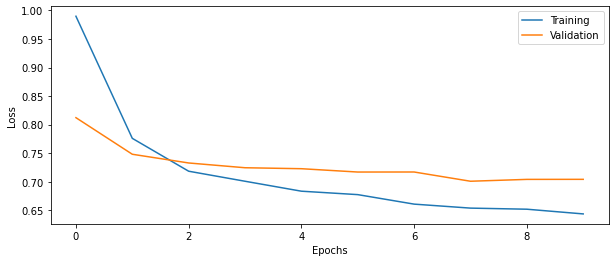

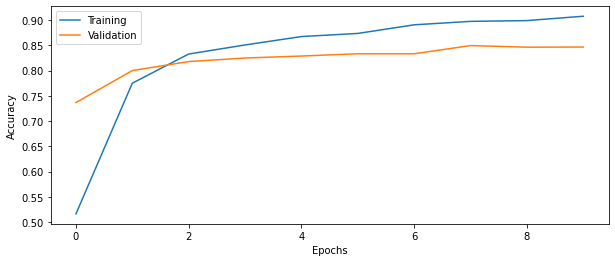

In [183]:
batch_size = 16
epochs = 10
history5 = model5.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)

plot_results(history5)

In [184]:
pred5 = model5.predict_classes(X_test)
print(classification_report(y_test, pred5, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.83      0.88      0.85      2555
     Neutral       0.81      0.79      0.80      1250
    Positive       0.89      0.84      0.87      2939

    accuracy                           0.85      6744
   macro avg       0.84      0.84      0.84      6744
weighted avg       0.85      0.85      0.85      6744



## Model6

In [185]:
model6 = rnnModel(embedding_dim=200, hidden_dim=200, n_dense_layers=2, denseLayerAct='sigmoid',n_nodes=128)
print(model6.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 63, 200)           8117600   
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 63, 400)           641600    
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 400)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                25664     
_________________________________________________________________
dense_23 (Dense)             (None, 42)                2730      
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 129       
Total params: 8,787,723
Trainable params: 8,787,723
Non-trainable params: 0
___________________________________________

Epoch 1/10
1075/1075 [==============================] - 238s 221ms/step - loss: 0.9315 - accuracy: 0.5986 - val_loss: 0.8010 - val_accuracy: 0.7595
Epoch 2/10
1075/1075 [==============================] - 239s 222ms/step - loss: 0.7021 - accuracy: 0.8484 - val_loss: 0.7007 - val_accuracy: 0.8498
Epoch 3/10
1075/1075 [==============================] - 240s 223ms/step - loss: 0.6556 - accuracy: 0.8949 - val_loss: 0.6891 - val_accuracy: 0.8598
Epoch 4/10
1075/1075 [==============================] - 237s 221ms/step - loss: 0.6376 - accuracy: 0.9135 - val_loss: 0.6862 - val_accuracy: 0.8629
Epoch 5/10
1075/1075 [==============================] - 236s 220ms/step - loss: 0.6242 - accuracy: 0.9263 - val_loss: 0.6906 - val_accuracy: 0.8595
Epoch 6/10
1075/1075 [==============================] - 237s 221ms/step - loss: 0.6163 - accuracy: 0.9349 - val_loss: 0.6872 - val_accuracy: 0.8619
Epoch 7/10
1075/1075 [==============================] - 240s 223ms/step - loss: 0.6131 - accuracy: 0.9378 - val_

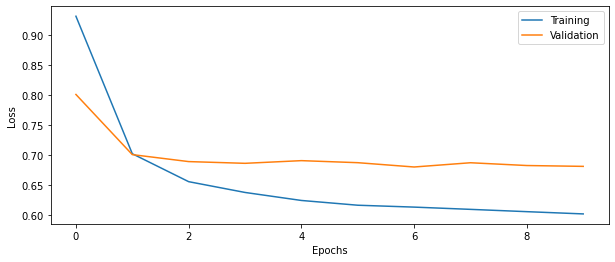

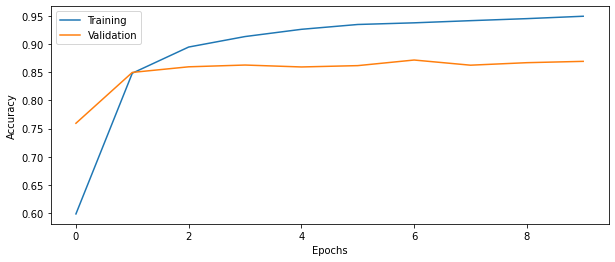

In [186]:
batch_size = 32
epochs = 10
history6 = model6.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)

plot_results(history6)

In [187]:
pred6 = model6.predict_classes(X_test)
print(classification_report(y_test, pred6, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.88      0.84      0.86      2555
     Neutral       0.86      0.83      0.84      1250
    Positive       0.86      0.90      0.88      2939

    accuracy                           0.87      6744
   macro avg       0.86      0.86      0.86      6744
weighted avg       0.87      0.87      0.87      6744



## model7

In [188]:
model7 = rnnModel(embedding_dim=200)
print(model7.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 63, 200)           8117600   
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 63, 200)           240800    
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 200)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 603       
Total params: 8,359,003
Trainable params: 8,359,003
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/10
538/538 [==============================] - 88s 164ms/step - loss: 0.8675 - accuracy: 0.6739 - val_loss: 0.7174 - val_accuracy: 0.8344
Epoch 2/10
538/538 [==============================] - 87s 163ms/step - loss: 0.6722 - accuracy: 0.8804 - val_loss: 0.6953 - val_accuracy: 0.8535
Epoch 3/10
538/538 [==============================] - 89s 165ms/step - loss: 0.6309 - accuracy: 0.9211 - val_loss: 0.6890 - val_accuracy: 0.8608
Epoch 4/10
538/538 [==============================] - 90s 167ms/step - loss: 0.6150 - accuracy: 0.9365 - val_loss: 0.6835 - val_accuracy: 0.8679
Epoch 5/10
538/538 [==============================] - 89s 166ms/step - loss: 0.6059 - accuracy: 0.9456 - val_loss: 0.6788 - val_accuracy: 0.8723
Epoch 6/10
538/538 [==============================] - 90s 168ms/step - loss: 0.6013 - accuracy: 0.9504 - val_loss: 0.6827 - val_accuracy: 0.8658
Epoch 7/10
538/538 [==============================] - 89s 166ms/step - loss: 0.5973 - accuracy: 0.9546 - val_loss: 0.6838 - val_ac

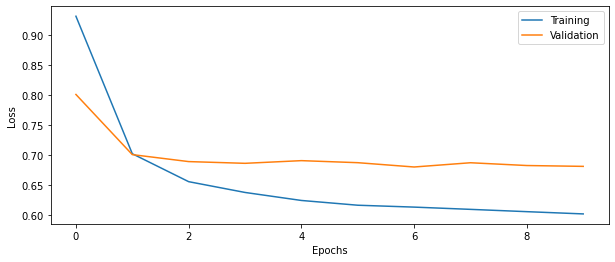

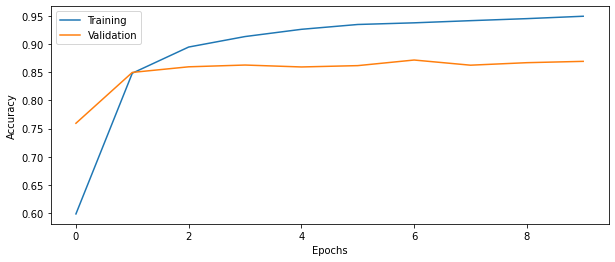

In [189]:
batch_size = 64
epochs = 10
history7 = model7.fit(X_train, y_train,
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose=1,
                   validation_split=0.1)

plot_results(history6)

In [190]:
pred7 = model7.predict_classes(X_test)
print(classification_report(y_test, pred7, target_names=targetLabels))

              precision    recall  f1-score   support

    Negative       0.89      0.85      0.87      2555
     Neutral       0.88      0.82      0.85      1250
    Positive       0.85      0.91      0.88      2939

    accuracy                           0.87      6744
   macro avg       0.87      0.86      0.87      6744
weighted avg       0.87      0.87      0.87      6744

